In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignment/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignment/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignment/assignment1


# Softmax Classifier exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

*完成本工作表（包括其输出和工作表之外的任何辅助代码），并在提交作业时一并提交。更多详情，请参阅课程网站上的[作业页面](http://vision.stanford.edu/teaching/cs231n/assignments.html)。*

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier.为 Softmax 分类器实现完全矢量化的**损失函数**。
- implement the fully-vectorized expression for its **analytic gradient**实现其**分析梯度**的全矢量化表达式
- **check your implementation** using numerical gradient使用数值梯度**检查你的实现**
- use a validation set to **tune the learning rate and regularization** strength使用验证集来**调整学习率和正则化**强度
- **optimize** the loss function with **SGD**用**SGD**优化**损失函数
- **visualize** the final learned weights**可视化**最终学习到的权重



In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


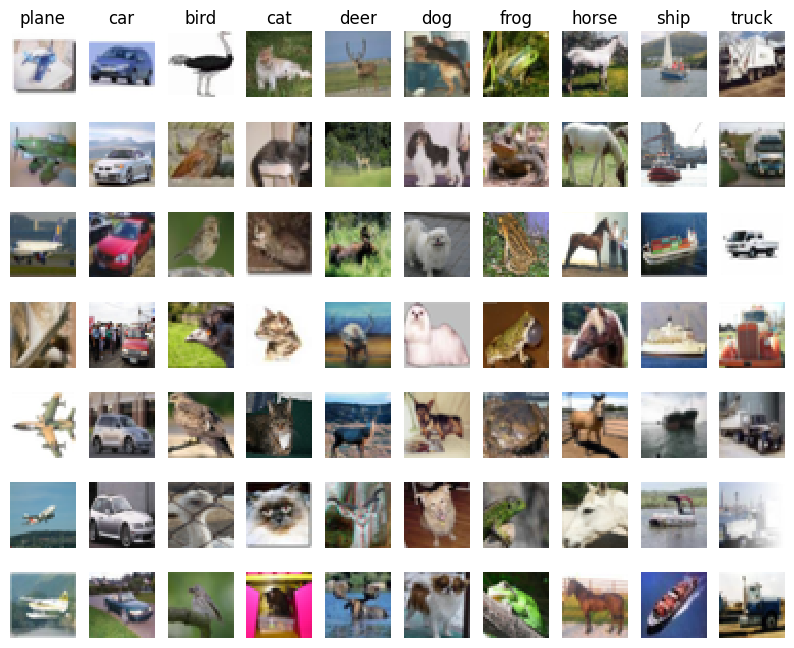

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
# 将数据分成训练集、验证集和测试集。此外，我们还将创建一个小型开发集，作为训练数据的子集；
# 我们可以用它来进行开发，这样代码运行起来会更快。
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
# 我们的验证集将是原始训练集上的 num_validation 点。
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
# 我们的训练集将是原始训练集中的第一个 num_train 点。
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
# 我们还将制作一个开发集，它是训练集的一个小子集。
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
# 我们使用原始测试集中的第一个 num_test 点作为我们的测试集。
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


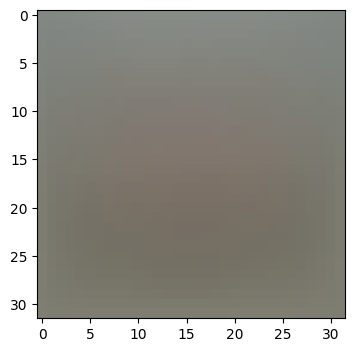

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
# 预处理：减去图像平均值
# 首先：根据训练数据计算图像平均值
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
# 第二步：从训练数据和测试数据中减去平均图像
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
# 第三：添加 1 的偏差维度（即偏差技巧），这样我们的分类器只需担心优化单一权重矩阵W
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.

As you can see, we have prefilled the function `softmax_loss_naive` which uses for loops to evaluate the softmax loss function.

本节的代码将全部写入 `cs231n/classifiers/softmax.py`。

如您所见，我们已经预填充了函数 `softmax_loss_naive`，该函数使用 for 循环来评估 softmax 损失函数。

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.softmax import softmax_loss_naive
import time

# generate a random Softmax classifier weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.313324
loss: 2.313324
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.为什么我们预期损失接近-log(0.1)？

$\color{blue}{\textit Your Answer:}$ *Fill this in*

Softmax 会将每类得分 $s_j$ 映射为概率分布 $p_j$：

$$
p_j = \frac{e^{s_j}}{\sum_{k=1}^{C} e^{s_k}}
$$

其使用的损失是 **交叉熵损失**（Cross-Entropy Loss）即

$$
L_i = -\log(p_{y_i})
$$

也就是对正确类别的概率取负对数。如果模型“确信”某类是正确的（例如 $p_{y_i} \to 1$），那么 $-\log(p_{y_i})$ 趋近于 0；反之，越不确定则损失越大。

一开始权重 `W` 是随机初始化的如：

```python
W = np.random.randn(D, C) * 0.0001
```

意味着每一类的得分 $s_j$ 都很小（接近 0），所以 exponentials $e^{s_j}$ 都差不多，得到的 softmax 概率几乎均匀分布：

$$
p_j \approx \frac{1}{C} = \frac{1}{10} = 0.1
$$

所以初始损失是

$$
L_i = -\log(p_{y_i}) = -\log(0.1)
$$


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the softmax loss function and implement it inline inside the function `softmax_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

上述函数返回的 `grad` 现在全部为零。推导并实现 softmax 损失函数的梯度，并在函数 `softmax_loss_naive` 中内联实现。在现有函数中交错使用新代码会很有帮助。

为了检查您是否正确地实现了梯度，您可以数值估计损失函数的梯度，然后将数值估计值与您计算的梯度进行比较。我们提供的代码可以帮你做到这一点：

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 2.745403 analytic: 2.745402, relative error: 9.255495e-09
numerical: 1.094441 analytic: 1.094441, relative error: 4.784546e-08
numerical: -0.255062 analytic: -0.255062, relative error: 1.404445e-07
numerical: -1.847090 analytic: -1.847089, relative error: 1.782871e-08
numerical: 0.608417 analytic: 0.608416, relative error: 1.112344e-08
numerical: -0.849523 analytic: -0.849523, relative error: 6.596576e-08
numerical: -0.611858 analytic: -0.611858, relative error: 8.162585e-09
numerical: 3.063358 analytic: 3.063358, relative error: 1.687023e-08
numerical: -2.683405 analytic: -2.683405, relative error: 1.541351e-08
numerical: 1.844189 analytic: 1.844189, relative error: 2.793073e-09
numerical: 1.791882 analytic: 1.791882, relative error: 1.052806e-08
numerical: -3.516839 analytic: -3.516839, relative error: 3.139662e-09
numerical: 1.197916 analytic: 1.197915, relative error: 3.322641e-08
numerical: 2.667743 analytic: 2.667743, relative error: 1.492622e-08
numerical: 0.267301 an

**Inline Question 2**

Although gradcheck is reliable softmax loss, it is possible that for SVM loss, once in a while, a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a svm loss gradient check could fail? How would change the margin affect of the frequency of this happening?


虽然 gradcheck 是可靠的 softmax loss，但对于 SVM loss 而言，偶尔可能会出现 gradcheck 中的某个维度不完全匹配的情况。造成这种差异的原因是什么？这是否值得担心？在一个维度上，SVM 损失梯度检查可能失败的简单例子是什么？改变边距会如何影响发生这种情况的频率？

Note that SVM loss for a sample $(x_i, y_i)$ is defined as: $$L_i = \sum_{j\ne y_i}\max(0, s_j - s_{y_i} + \Delta)$$ where $j$ iterates over all classes except the correct class $y_i$ and $s_j$ denotes the classifier score for $j^{th}$ class. $\Delta$ is a scalar margin. For more information, refer to 'Multiclass Support Vector Machine loss' on [this](https://cs231n.github.io/linear-classify/) page.

其中，$j$遍历除正确类别$y_i$之外的所有类别，$s_j$表示分类器对$j^{th}$类别的评分。$\Delta$ 是一个标量边际值。更多信息，请参阅本页面上的 "多类支持向量机损失"。

*Hint: the SVM loss function is not strictly speaking differentiable.*


*提示：严格来说，SVM 损失函数并不是可微分的。


$\color{blue}{\textit Your Answer:}$ *fill this in.*  


SVM损失函数在某些点上不可导，特别是当 $s_j - s_{y_i} + \Delta = 0$ 时，梯度存在不确定性。此时数值梯度的估计值可能与解析导数不同，导致梯度检查失败。出现这种情况是由于损失函数本身的不光滑性，并不是实现错误。

例如，在一维情况下，当某个类别得分恰好落在边界上时，导数可能跳变，这种断点会引起检查误差。随着（$\Delta$）增大，更多样本会落在边界附近，非可导点也会变多，梯度检查失败的概率也会因此上升。

In [10]:
# Next implement the function softmax_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
# 接下来执行 softmax_loss_vectorized 函数；现在只计算损失；
# 我们稍后将实现梯度。
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, _ = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
# 损失应该相符，但你的矢量化实现应该更快。
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 2.313324e+00 computed in 0.063951s
Vectorized loss: 2.313324e+00 computed in 0.011498s
difference: 0.000000


In [11]:
# Complete the implementation of softmax_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.
# 完成 softmax_loss_vectorized 的实现，并计算损失函数的梯度。

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
# 朴素的实现和矢量化的实现应该是一致的，但矢量化版本应该更快。
tic = time.time()
_, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
# 损失是一个单一的数字，因此很容易比较两种实现方法计算出的值。
# 另一方面，梯度是一个矩阵，所以我们使用弗罗贝尼斯规范来比较它们。
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.061728s
Vectorized loss and gradient: computed in 0.009779s
difference: 0.000000


### Stochastic Gradient Descent

### 随机梯度下降

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.


我们现在有了损失、梯度的高效向量表达式，而且我们的梯度与数值梯度相匹配。因此，我们可以用随机梯度下降法来最小化损失了。这部分的代码将写入 `cs231n/classifiers/linear_classifier.py`。

In [12]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
# 在文件 linear_classifier.py 中，在函数LinearClassifier.train()，然后用下面的代码运行它。
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 769.246530
iteration 100 / 1500: loss 281.883665
iteration 200 / 1500: loss 104.430806
iteration 300 / 1500: loss 39.519635
iteration 400 / 1500: loss 15.814705
iteration 500 / 1500: loss 7.090301
iteration 600 / 1500: loss 3.954565
iteration 700 / 1500: loss 2.734569
iteration 800 / 1500: loss 2.335199
iteration 900 / 1500: loss 2.158852
iteration 1000 / 1500: loss 2.174643
iteration 1100 / 1500: loss 2.144991
iteration 1200 / 1500: loss 2.064786
iteration 1300 / 1500: loss 2.086505
iteration 1400 / 1500: loss 2.121359
That took 9.266594s


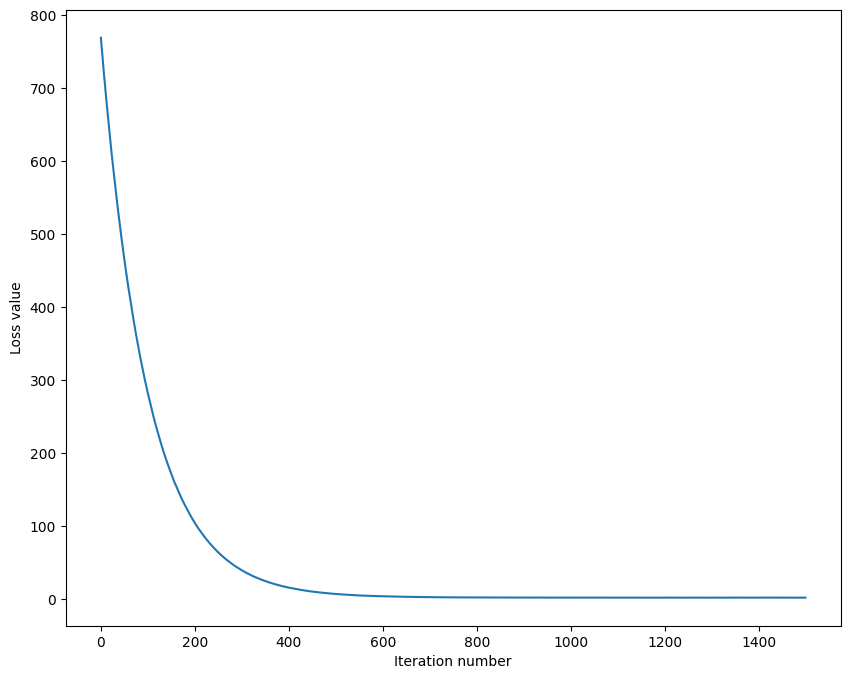

In [13]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
# 一个有用的调试策略是绘制损失与迭代次数的函数：
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [14]:
# Write the LinearClassifier.predict function and evaluate the performance on
# both the training and validation set
# You should get validation accuracy of about 0.34 (> 0.33).
# 编写 LinearClassifier.predict 函数，并对训练集和验证集的性能进行评估。
# 您应该得到约 0.34（> 0.33）的验证准确率。
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.328592
validation accuracy: 0.341000


In [15]:
# Save the trained model for autograder.
# 为 autograder 保存训练好的模型。
softmax.save("softmax.npy")

softmax.npy saved.


In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.365 (> 0.36) on the validation set.
# 使用验证集来调整超参数（正则化强度和学习率）。你应该尝试使用
# 学习率和正则化强度的不同范围；如果你小心谨慎，你应该能在验证集上获得约 0.365（> 0.36）的分类准确率。

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.
# 注意：在超参数搜索过程中，可能会出现运行时间/溢出警告。
# 这可能是极端值造成的，并非错误。

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
# 结果是一个字典，它将形式为(learning_rate, regularization_strength) 的元组映射到(training_accuracy, validation_accuracy) 的元组。
# 准确率是被正确分类的数据点的分数。
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a Softmax on the.        #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the Softmax object that achieves this.   #
# accuracy in best_softmax.                                                    #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the classifiers don't take much time to train; once  #
# you are confident that your validation code works, you should rerun the      #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        # 初始化
        softmax = Softmax()

        # 训练
        loss_hist = softmax.train(
            X_train, y_train,
            learning_rate=lr,
            reg=reg,
            num_iters=1500,
            verbose=False
        )

        # 在训练集上预测
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)

        # 在验证集上预测
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)

        # 存结果
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # 如果验证集表现更好，更新最佳模型
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax


# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-6]
regularization_strengths = [2.5e4, 1e4]



# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.356592 val accuracy: 0.365000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.335286 val accuracy: 0.352000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.350837 val accuracy: 0.365000
lr 1.000000e-06 reg 2.500000e+04 train accuracy: 0.317918 val accuracy: 0.324000
best validation accuracy achieved during cross-validation: 0.365000


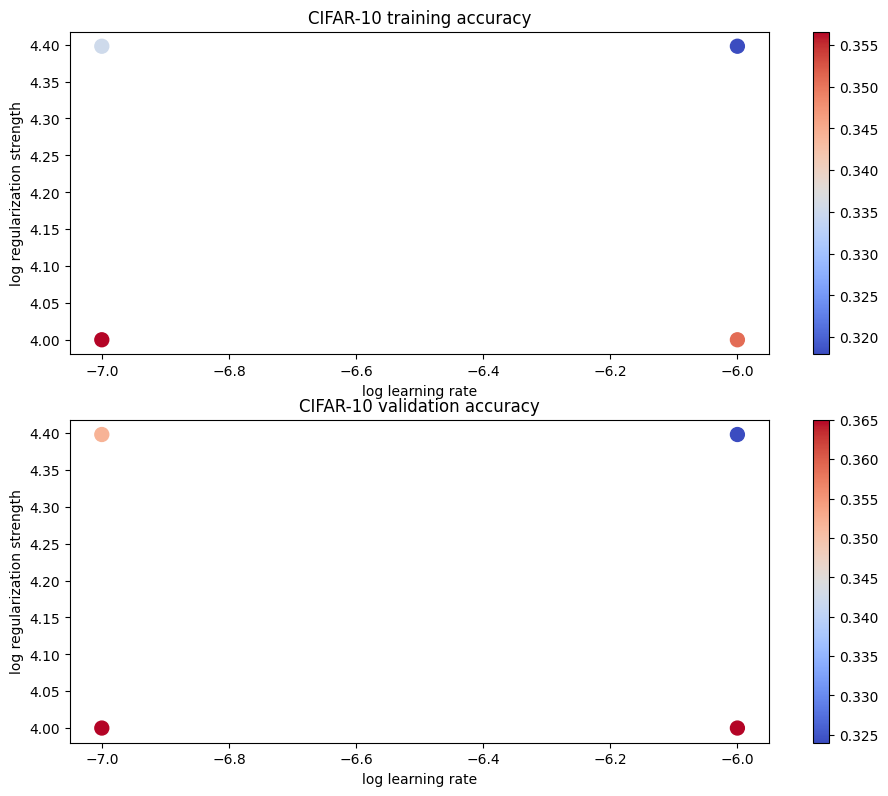

In [18]:
# Visualize the cross-validation results
# 交叉验证结果可视化
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [19]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax classifier on raw pixels final test set accuracy: %f' % test_accuracy)

Softmax classifier on raw pixels final test set accuracy: 0.364000


In [20]:
# Save best softmax model
best_softmax.save("best_softmax.npy")

best_softmax.npy saved.


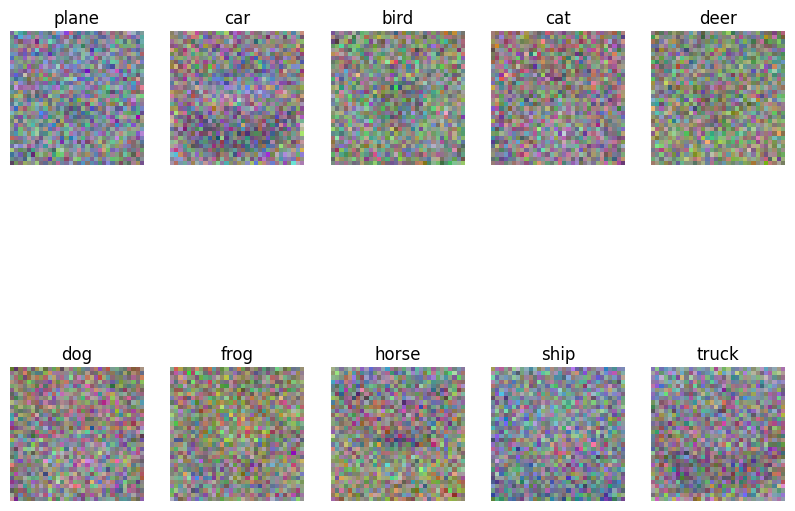

In [21]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
# 可视化每个类别的学习权重。
# 根据你对学习率和正则化强度的选择，这些权重可能好看，也可能不好看。
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 3**

Describe what your visualized Softmax classifier weights look like, and offer a brief explanation for why they look the way they do.

描述可视化 Softmax 分类器权重的外观，并简要解释其外观的原因。

$\color{blue}{\textit Your Answer:}$ *fill this in*  

Softmax 分类器的权重图像大致呈现出每个类别的“平均外观”，通常是模糊的色块图，反映了该类图像的主要颜色和结构倾向。这是因为 softmax 是线性模型，只能从全局像素颜色中提取类别相关信息，不能捕捉复杂结构。这也解释了为什么 softmax 分类效果不如神经网络。


**Inline Question 4** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would change the softmax loss, but leave the SVM loss unchanged.

假设总体训练损失被定义为所有训练实例的每个数据点损失之和。在训练集中添加一个新的数据点可能会改变 softmax 损失，但 SVM 损失不会改变。

$\color{blue}{\textit Your Answer:}$

对的

$\color{blue}{\textit Your Explanation:}$

Softmax 损失基于概率建模，它会对每一个样本都进行非零的梯度更新。即使一个样本分类正确、预测概率也很高，它对 loss 的贡献依然是 $-\log(p_{y})$，只不过这个值会很小。因此，**增加任何新样本都会改变总 loss**，除非这个样本恰好和已有样本完全相同。

SVM 的损失基于间隔（margin）。如果某个样本的预测已经满足了正确类别与错误类别之间的 margin（即 `s_y ≥ s_j + Δ` 对所有 $j ≠ y$ 成立），则该样本的 loss 为 0，对权重不产生任何更新。因此，**如果新加入的样本已经被模型很好地分类（满足 margin 要求），它对总 loss 没有任何影响**。

因此确实存在这样的情况：一个新样本满足 SVM 的 margin 条件，对 SVM loss 没有影响；但由于 Softmax 总是对每个样本分配非零损失，加入这个样本后 Softmax loss 会发生改变，所以这句话是对的

